# Example 1
---

This notebook demonstrates how to obtain differential and total cross sections for upscattering processes.

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import matplotlib.pyplot as plt
import numpy as np

import DarkNews as dn
from DarkNews import pdg

import matplotlib.pyplot as plt

### 1) First cross checks of NC cross sections

Let's check that the `neutral current` cross section behaves like the SM one in the low-energy limit. We compare our Z exchange xsec with the total neutrino xsecs (file taken from GLoBES, refs: Messier:1999kj, Paschos:2001np)

We currently do not have the DIS regime included, so we expect agreement only at the lowest energies.

--- 
We start by defining an instance of a model with no additional new physics on top of the minimal HNL model (only nu-N mixing).

Then we define instances of XsecCalc, which is our xsec calculator object. They can compute differential cross sections (in Q^2) or total cross sections (integrated with Vegas). We are interested in the latter here.


In [26]:
# targets
proton = dn.detector.NuclearTarget("H1")
C12    = dn.detector.NuclearTarget("C12")
Ar40   = dn.detector.NuclearTarget("Ar40")

In [58]:
# model
NC_test   = dn.model.ThreePortalModel(name='NC_test', m4 = 0.001, Umu4=1e-3, epsilon=0.0, gD=0.0)

# xsec calculators
common_kwargs = {'nu_projectile': pdg.numu, 'nu_upscattered': pdg.neutrino4, 'helicity': 'conserving', 'nuclear_target': C12}
calc_NC_coh   = dn.UpscatteringProcess(TheoryModel = NC_test, scattering_regime = 'coherent', **common_kwargs) 
calc_NC_pel   = dn.UpscatteringProcess(TheoryModel = NC_test, scattering_regime = 'p-el', **common_kwargs) 
calc_NC_nel   = dn.UpscatteringProcess(TheoryModel = NC_test, scattering_regime = 'n-el', **common_kwargs) 

# calculating them
Enu_range = np.geomspace(0.01,2e2,50)
xsecs_NC = (calc_NC_coh.total_xsec(Enu_range, NEVAL=1000, NINT=10), 
            calc_NC_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10),
            calc_NC_nel.total_xsec(Enu_range, NEVAL=1000, NINT=10))


---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).



In [59]:
maj_test   = dn.model.ThreePortalModel(name='maj_test', m4 = 0.1, Umu4=np.sqrt(2.2e-7), epsilon2=4.6e-4, alphaD=0.4, UD4=1, HNLtype='majorana', mzprime=1.25)
dir_test   = dn.model.ThreePortalModel(name='dirac_test', m4 = 0.1, Umu4=np.sqrt(2.2e-7), epsilon2=4.6e-4, alphaD=0.4, UD4=1, HNLtype='dirac', mzprime=1.25)

calc_maj_coh   = dn.UpscatteringProcess(TheoryModel = maj_test, scattering_regime = 'coherent', **common_kwargs) 
calc_dir_coh   = dn.UpscatteringProcess(TheoryModel = dir_test, scattering_regime = 'coherent', **common_kwargs) 

print(f'maj: tot_sigma = {calc_maj_coh.total_xsec(1.0, NEVAL=1000, NINT=10)}')
print(f'dir: tot_sigma = {calc_dir_coh.total_xsec(1.0, NEVAL=1000, NINT=10)}')


---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

maj: tot_sigma = 3.949589436847565e-40
dir: tot_sigma = 3.96668183402196e-40


Text(0, 0.5, '$d\\sigma/dQ^2$ (cm$^2$)')

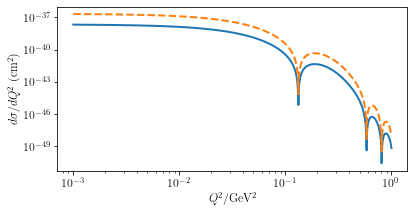

In [19]:
q2=np.geomspace(1e-3,1,1000)

fig, ax = dn.plot_tools.std_fig(figsize=(6,3))

ax.plot(q2,calc_maj_coh.diff_xsec_Q2(1,q2),label='majorana', lw=2)
ax.plot(q2,calc_dir_coh.diff_xsec_Q2(1,q2),ls='--',label='dirac', lw=2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$Q^2$/GeV$^2$")
ax.set_ylabel(r"$d\sigma/dQ^2$ (cm$^2$)")

Now we see that the NC scattering on neutrons matches the one obtained from GLoBES reasonably well, except at high energies, where the DIS cross section, which we do not model, dominates.

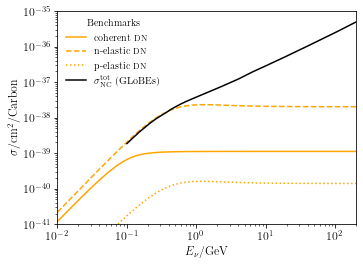

In [20]:
# create fig
fig, ax = dn.plot_tools.std_fig(ax_form=[0.15,0.15,0.83,0.74], figsize=(5,4))

dn_logo = r"{\footnotesize \textsc{DN}}"
ax.plot(Enu_range, 1e6*xsecs_NC[0], label=rf"coherent {dn_logo}", c='orange')
ax.plot(Enu_range, 1e6*xsecs_NC[2]*6, ls='--', label=rf"n-elastic {dn_logo}", c='orange')
ax.plot(Enu_range, 1e6*xsecs_NC[1]*6, ls=':', label=rf"p-elastic {dn_logo}", c='orange')

# GLoBES file
loge, *sigma = np.genfromtxt("aux_data/XNC.dat", unpack=True)
enu = 10**loge
ax.plot(enu, sigma[1]*1e-38*enu*12, c='black', label=r'$\sigma_{\rm NC}^{\rm tot}$ (GLoBEs)')

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(frameon=False, loc='upper right')
ax.set_xlim(min(Enu_range), max(Enu_range))
ax.set_ylim(1e-41,1e-35)
leg = ax.legend(frameon=False, loc = "upper left", title=r'Benchmarks')
ax.set_xlabel(r'$E_\nu$/GeV')
ax.set_ylabel(r'$\sigma$/cm$^2$/Carbon')

dn.plot_tools.std_savefig(fig, "plots/example_2_xsec_NC.pdf",dpi=400)

### 2) Now we compare different new physics models

We will focus on a couple of benchmark models:

* Vergano et al BP __[2105.06470](arxiv.org/abs/2105.06470)__

* Bertuzzo et al BP __[1807.09877](arxiv.org/abs/1807.09877)__

* Ballett et al BP __[1903.07589](arxiv.org/abs/1903.07589)__

* Abdullahi et al BP __[2007.11813](arxiv.org/abs/2007.11813)__

* Abdallah et al BP __[2202.09373](arxiv.org/abs/2202.09373)__

In [34]:
# create models
vergani_et_al   = dn.model.ThreePortalModel(name='vergani_et_al', m4 = 0.200, Umu4=0.0, epsilon=0.0, mu_tr_mu4=4e-7)
bertuzzo_et_al  = dn.model.ThreePortalModel(name='bertuzzo_et_al', m4 = 0.420, Umu4=np.sqrt(9e-7), Umu5=0.0, UD5=0.0, alpha_epsilon2=2e-10, alphaD=0.25, mzprime=0.03)
ballett_et_al   = dn.model.ThreePortalModel(name='ballett_et_al', m5 = 0.150, m4 = 0.107, mzprime=1.25,
                                                            Umu4=np.sqrt(1.5e-6), Umu5=np.sqrt(0.85e-6), 
                                                            UD5=np.sqrt(4/11), UD4=np.sqrt(7/11), 
                                                            chi=np.sqrt(1e-5), gD=2)
abdullahi_et_al = dn.model.ThreePortalModel(name='abdullahi_et_al', m4=0.074, m5 = 0.146, Umu4=0, UD4=0, UD5=1.0, Umu5=np.sqrt(3e-7), alphaD=0.3, epsilon=2.2e-2, mzprime=1.25)
abdallah_et_al = dn.model.ThreePortalModel(name='abdallah_et_al', m4=0.074, m5 = 0.146, Umu4=0, UD4=0, UD5=1.0, Umu5=np.sqrt(3e-7), alphaD=0.3, epsilon=2.2e-2, mzprime=1.25)
scalar_l   = dn.model.ThreePortalModel(name='light scalar', m4 = 0.200, s_mu4=1e-3, Umu4=0.0, theta=1e-3, mhprime=0.03, epsilon=0.0, gD=0.0)

# dipole interaction flips helicity while dark photon conserves it -- the other helicity channel can be computed, but will be subdominant.
common_kwargs = {'nu_projectile': pdg.numu, 'scattering_regime': 'coherent', 'nuclear_target': C12}
calculator_vergani   = dn.UpscatteringProcess(TheoryModel = vergani_et_al, helicity = 'flipping', nu_upscattered=vergani_et_al.neutrino4, **common_kwargs) 
calculator_bertuzzo  = dn.UpscatteringProcess(TheoryModel = bertuzzo_et_al, helicity = 'conserving', nu_upscattered=bertuzzo_et_al.neutrino4, **common_kwargs)
calculator_ballett   = dn.UpscatteringProcess(TheoryModel = ballett_et_al, helicity = 'conserving', nu_upscattered=ballett_et_al.neutrino5, **common_kwargs)
calculator_abdullahi = dn.UpscatteringProcess(TheoryModel = abdullahi_et_al, helicity = 'conserving', nu_upscattered=abdullahi_et_al.neutrino5, **common_kwargs)
calculator_abdallah = dn.UpscatteringProcess(TheoryModel = abdallah_et_al, helicity = 'flipping', nu_upscattered=abdallah_et_al.neutrino5, **common_kwargs)

common_kwargs = {'nu_projectile': pdg.numu, 'scattering_regime': 'p-el', 'nuclear_target': C12}
calculator_vergani_pel   = dn.UpscatteringProcess(TheoryModel = vergani_et_al, helicity = 'flipping',     nu_upscattered=vergani_et_al.neutrino4, **common_kwargs) 
calculator_bertuzzo_pel  = dn.UpscatteringProcess(TheoryModel = bertuzzo_et_al, helicity = 'conserving',  nu_upscattered=bertuzzo_et_al.neutrino4, **common_kwargs)
calculator_ballett_pel   = dn.UpscatteringProcess(TheoryModel = ballett_et_al, helicity = 'conserving',   nu_upscattered=ballett_et_al.neutrino5, **common_kwargs)
calculator_abdullahi_pel = dn.UpscatteringProcess(TheoryModel = abdullahi_et_al, helicity = 'conserving', nu_upscattered=abdullahi_et_al.neutrino5, **common_kwargs)
calculator_abdallah_pel = dn.UpscatteringProcess(TheoryModel = abdallah_et_al, helicity = 'conserving', nu_upscattered=abdallah_et_al.neutrino5, **common_kwargs)

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

---------------------------------------------------------
Model:
	2 dirac heavy neutrino(s).

---------------------------------------------------------
Model:
	2 dirac heavy neutrino(s).

---------------------------------------------------------
Model:
	2 dirac heavy neutrino(s).

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).



In [35]:
Enu_range=np.linspace(0,2,50)

vergani = (calculator_vergani.total_xsec(Enu_range, NEVAL=1000, NINT=10), calculator_vergani_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10))
bertuzzo = (calculator_bertuzzo.total_xsec(Enu_range, NEVAL=1000, NINT=10), calculator_bertuzzo_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10))
ballett = (calculator_ballett.total_xsec(Enu_range, NEVAL=1000, NINT=10), calculator_ballett_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10))
abdullahi = (calculator_abdullahi.total_xsec(Enu_range, NEVAL=1000, NINT=10), calculator_abdullahi_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10))


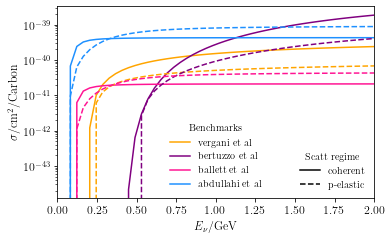

In [36]:
fig, ax = dn.plot_tools.std_fig(ax_form=[0.1,0.15,0.88,0.74], figsize=(5,3.6))

l1,= ax.plot(Enu_range, vergani[0], label=calculator_vergani.TheoryModel.name.replace("_"," "), c='orange')
l2,= ax.plot(Enu_range, bertuzzo[0], label=calculator_bertuzzo.TheoryModel.name.replace("_"," "), c='purple')
l3,= ax.plot(Enu_range, ballett[0], label=calculator_ballett.TheoryModel.name.replace("_"," "), c='deeppink')
l4,= ax.plot(Enu_range, abdullahi[0], label=calculator_abdullahi.TheoryModel.name.replace("_"," "), c='dodgerblue')

ax.plot(Enu_range, vergani[1], ls='--', c='orange')
ax.plot(Enu_range, bertuzzo[1], ls='--', c='purple')
ax.plot(Enu_range, ballett[1], ls='--', c='deeppink')
ax.plot(Enu_range, abdullahi[1], ls='--', c='dodgerblue')

# ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(frameon=False, loc='upper right')
ax.set_xlim(min(Enu_range), max(Enu_range))
# ax.set_ylim(1e-42,5e-38)


proxy, = plt.plot([0,0],[0,0],linestyle='-',color='black')
proxy2, = plt.plot([0,0],[0,0],linestyle='--',color='black')
leg = ax.legend(handles=[l1,l2,l3,l4], frameon=False, loc = "lower center", title=r'Benchmarks')
leg2 = ax.legend([proxy,proxy2], [r"coherent",r"p-elastic"], frameon=False, loc = "lower right", title=r'Scatt regime')
ax.add_artist(leg)


ax.set_xlabel(r'$E_\nu$/GeV')
ax.set_ylabel(r'$\sigma$/cm$^2$/Carbon')

plt.savefig("plots/example_2_xsec.pdf",dpi=400)

In [37]:
# create models
dipole   = dn.model.ThreePortalModel(name='dipole', m4 = 0.200, mu_tr_mu4=1e-6)
vector_h   = dn.model.ThreePortalModel(name='heavy vector', m4 = 0.200, epsilon=1e-3, Umu4=1e-3, mzprime=1.25)
vector_l   = dn.model.ThreePortalModel(name='light vector', m4 = 0.200, epsilon=1e-3, Umu4=1e-3, mzprime=0.03)
scalar_h   = dn.model.ThreePortalModel(name='heavy scalar', m4 = 0.200, s_mu4=1e-3, Umu4=0.0, theta=1e-3, mhprime=1.25, epsilon=0.0, gD=0.0)
scalar_l   = dn.model.ThreePortalModel(name='light scalar', m4 = 0.200, s_mu4=1e-3, Umu4=0.0, theta=1e-3, mhprime=0.03, epsilon=0.0, gD=0.0)

# dipole interaction flips helicity while dark photon conserves it -- the other helicity channel can be computed, but will be subdominant.
common_kwargs = {'nu_projectile': pdg.numu, 'scattering_regime': 'coherent', 'nuclear_target': C12}
calculator_dipole   = dn.UpscatteringProcess(TheoryModel = dipole, nu_upscattered=dipole.neutrino4, helicity = 'flipping', **common_kwargs)  
calculator_vector_h  = dn.UpscatteringProcess(TheoryModel = vector_h, nu_upscattered=vector_h.neutrino4, helicity = 'conserving',  **common_kwargs) 
calculator_vector_l   = dn.UpscatteringProcess(TheoryModel = vector_l, nu_upscattered=vector_l.neutrino4, helicity = 'conserving', **common_kwargs) 
calculator_scalar_h = dn.UpscatteringProcess(TheoryModel = scalar_h, nu_upscattered=scalar_h.neutrino4, helicity = 'flipping', **common_kwargs) 
calculator_scalar_l = dn.UpscatteringProcess(TheoryModel = scalar_l, nu_upscattered=scalar_l.neutrino4, helicity = 'flipping', **common_kwargs) 

common_kwargs['scattering_regime'] = 'p-el'
calculator_dipole_pel   = dn.UpscatteringProcess(TheoryModel = dipole, nu_upscattered=dipole.neutrino4, helicity = 'flipping', **common_kwargs) 
calculator_vector_h_pel  = dn.UpscatteringProcess(TheoryModel = vector_h, nu_upscattered=vector_h.neutrino4, helicity = 'conserving',  **common_kwargs)
calculator_vector_l_pel   = dn.UpscatteringProcess(TheoryModel = vector_l, nu_upscattered=vector_l.neutrino4, helicity = 'conserving', **common_kwargs)
calculator_scalar_h_pel = dn.UpscatteringProcess(TheoryModel = scalar_h, nu_upscattered=scalar_h.neutrino4, helicity = 'flipping', **common_kwargs)
calculator_scalar_l_pel = dn.UpscatteringProcess(TheoryModel = scalar_l, nu_upscattered=scalar_l.neutrino4, helicity = 'flipping', **common_kwargs)

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).



In [38]:
Enu_range=np.linspace(0,2,50)

dipole_xs = (calculator_dipole.total_xsec(Enu_range, NEVAL=1000, NINT=10), calculator_dipole_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10))
vector_h_xs = (calculator_vector_h.total_xsec(Enu_range, NEVAL=1000, NINT=10), calculator_vector_h_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10))
vector_l_xs = (calculator_vector_l.total_xsec(Enu_range, NEVAL=1000, NINT=10), calculator_vector_l_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10))
scalar_h_xs = (calculator_scalar_h.total_xsec(Enu_range, NEVAL=1000, NINT=10), calculator_scalar_h_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10))
scalar_l_xs = (calculator_scalar_l.total_xsec(Enu_range, NEVAL=1000, NINT=10), calculator_scalar_l_pel.total_xsec(Enu_range, NEVAL=1000, NINT=10))


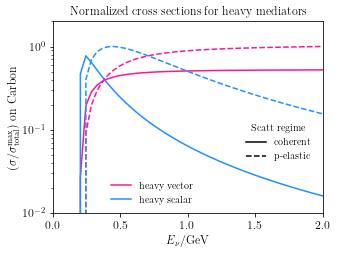

In [47]:
fig, ax = dn.plot_tools.std_fig(ax_form=[0.2,0.15,0.75,0.74], figsize=(5,3.6))


l2,= ax.plot(Enu_range, vector_h_xs[0]/np.max(vector_h_xs), label=vector_h.name.replace("_"," "), c='deeppink')
l4,= ax.plot(Enu_range, scalar_h_xs[0]/np.max(scalar_h_xs), label=scalar_h.name.replace("_"," "), c='dodgerblue')

ax.plot(Enu_range, vector_h_xs[1]/np.max(vector_h_xs), ls='--', c='deeppink')
ax.plot(Enu_range, scalar_h_xs[1]/np.max(scalar_h_xs), ls='--', c='dodgerblue')


# ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(frameon=False, loc='upper right')
ax.set_xlim(min(Enu_range), max(Enu_range))
ax.set_ylim(1e-2,2)


proxy, = plt.plot([0,0],[0,0],linestyle='-',color='black')
proxy2, = plt.plot([0,0],[0,0],linestyle='--',color='black')
leg = ax.legend(handles=[l2,l4], frameon=False, loc = (0.2,0.025), title=r'')
leg2 = ax.legend([proxy,proxy2], [r"coherent",r"p-elastic"], frameon=False, loc = (0.7,0.25), title=r'Scatt regime')
ax.add_artist(leg)
ax.set_title(r"Normalized cross sections for heavy mediators")


ax.set_xlabel(r'$E_\nu$/GeV')
ax.set_ylabel(r'$(\sigma/\sigma^{\rm max}_{\rm total}$) on Carbon')

dn.plot_tools.std_savefig(fig, "plots/example_2_xsec_int_type_heavy.png",dpi=400)

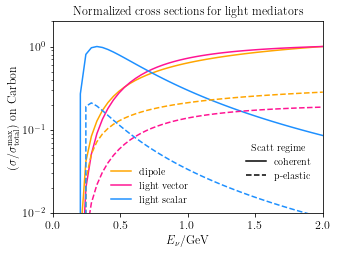

In [46]:
fig, ax = dn.plot_tools.std_fig(ax_form=[0.2,0.15,0.75,0.74], figsize=(5,3.6))

l1,= ax.plot(Enu_range, dipole_xs[0]/np.max(dipole_xs), label=dipole.name.replace("_"," "), c='orange')
l3,= ax.plot(Enu_range, vector_l_xs[0]/np.max(vector_l_xs), label=vector_l.name.replace("_"," "), c='deeppink')
l5,= ax.plot(Enu_range, scalar_l_xs[0]/np.max(scalar_l_xs), label=scalar_l.name.replace("_"," "), c='dodgerblue')

ax.plot(Enu_range, dipole_xs[1]/np.max(dipole_xs), ls='--', c='orange')
ax.plot(Enu_range, vector_l_xs[1]/np.max(vector_l_xs), ls='--', c='deeppink')
ax.plot(Enu_range, scalar_l_xs[1]/np.max(scalar_l_xs), ls='--', c='dodgerblue')

# ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(frameon=False, loc='upper right')
ax.set_xlim(min(Enu_range), max(Enu_range))
ax.set_ylim(1e-2,2)


proxy, = plt.plot([0,0],[0,0],linestyle='-',color='black')
proxy2, = plt.plot([0,0],[0,0],linestyle='--',color='black')
leg = ax.legend(handles=[l1,l3,l5], frameon=False, loc = (0.2,0.025), title=r'')
leg2 = ax.legend([proxy,proxy2], [r"coherent",r"p-elastic"], frameon=False, loc = (0.7,0.15), title=r'Scatt regime')
ax.add_artist(leg)
ax.set_title(r"Normalized cross sections for light mediators")

ax.set_xlabel(r'$E_\nu$/GeV')
ax.set_ylabel(r'$(\sigma/\sigma^{\rm max}_{\rm total}$) on Carbon')

dn.plot_tools.std_savefig(fig, "plots/example_2_xsec_int_type_light.png",dpi=400)

## More cross sections

Now one can compute cross sections for a series of models and targets. The

Below, we define a function that computes several examples.

In [50]:
def compute_xsecs(m4, mzprime, **kwargs):
   
    #########################
    # Set BSM parameters
    bsm_model = dn.model.ThreePortalModel(mzprime=mzprime, m4 = m4, **kwargs)
    
    TARGETS = [proton, C12, Ar40]
    REGIMES = ['coherent','p-el']
    HEL_CASES = ['conserving','flipping']

    myMCs = {}
    for target in TARGETS:
        for regime in REGIMES:
            for hel in HEL_CASES:
                key = f'{target.name}_{hel}_{regime}'
                myMCs[key] = dn.UpscatteringProcess(  
                    TheoryModel = bsm_model, 
                    nu_projectile=pdg.numu,
                    nu_upscattered=pdg.neutrino4,
                    scattering_regime = regime,
                    nuclear_target= target,
                    helicity = hel)

    mc_lowT=myMCs['Ar40_conserving_coherent']

    enu_axis = np.geomspace(mc_lowT.Ethreshold*0.99, 20, 10)
    np.append(mc_lowT.Ethreshold*1.01, enu_axis)
    sigmas = {}
    for key, mc in myMCs.items():
        sigmas[key] = []
        print(key)
        sigmas[key] = mc.total_xsec(enu_axis)
        mc.sigmas = sigmas[key]
        mc.enu_axis = enu_axis
    return myMCs

In [51]:
mcs_H_150 = compute_xsecs(0.150, 1.25, HNLtype="majorana")
mcs_H_420 = compute_xsecs(0.420, 1.25, HNLtype="majorana")
mcs_L_150 = compute_xsecs(0.150, 0.03, HNLtype="majorana")
mcs_L_420 = compute_xsecs(0.420, 0.03, HNLtype="majorana")

---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).

H1_conserving_coherent
H1_flipping_coherent
H1_conserving_p-el
H1_flipping_p-el
C12_conserving_coherent
C12_flipping_coherent
C12_conserving_p-el
C12_flipping_p-el
Ar40_conserving_coherent
Ar40_flipping_coherent
Ar40_conserving_p-el
Ar40_flipping_p-el
---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).

H1_conserving_coherent
H1_flipping_coherent
H1_conserving_p-el
H1_flipping_p-el
C12_conserving_coherent
C12_flipping_coherent
C12_conserving_p-el
C12_flipping_p-el
Ar40_conserving_coherent
Ar40_flipping_coherent
Ar40_conserving_p-el
Ar40_flipping_p-el
---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).

H1_conserving_coherent
H1_flipping_coherent
H1_conserving_p-el
H1_flipping_p-el
C12_conserving_coherent
C12_flipping_coherent
C12_conserving_p-el
C12_flipping_p-el
Ar40_conserving_coherent
Ar40_flipping_co

In [53]:
def fix_label(label):
    return label.replace("_", " ").replace("conserving", "HC").replace("coherent", "coh").replace("flipping", "HF")

def plot_xsecs(theseMCs, regime = 'coherent'):
    fig, ax = dn.plot_tools.std_fig(figsize=(6,4))

    all_args={
            f'H1_conserving_{regime}': {'color': 'black', 'ls': '-'},
            f'C12_conserving_{regime}': {'color': 'royalblue', 'ls': '-'},
            f'Ar40_conserving_{regime}': {'color': 'violet', 'ls': '-'},
            f'H1_flipping_{regime}': {'color': 'black', 'ls': '--'},
            f'C12_flipping_{regime}': {'color': 'royalblue', 'ls': '--'},
            f'Ar40_flipping_{regime}': {'color': 'violet', 'ls': '--'},
            }    
    
    for key, mc in theseMCs.items():
        if regime in key:
            if regime == 'coherent' and "H1" in key:
                continue
            else:
                sigmas = mc.sigmas
                enu_axis = np.geomspace(mc.Ethreshold*0.99, 20, len(sigmas))

                ls = '-' if ('conserving' in key) else '--'
                args = all_args[key]
                p = mc.TheoryModel
                norm = (p.Umu4*p.epsilon*dn.const.eQED*p.gD*p.UD4*mc.target.Z)**2
#                 print(norm/(mc.Vij**2*mc.ups_case.Vhad**2))
                # if 'conserving' in key:
                ax.plot(enu_axis, sigmas/norm, label=fix_label(key), **args)
                # else:
                #     ax.plot(enu_axis, sigmas/norm, **args)

    ax.set_title(fr'$m_{{Z^\prime}}= {mc.mzprime:.2f}$ GeV,  $m_4 = {mc.m_ups*1e3:.0f}$ MeV')
    ax.set_yscale("log")
    # ax.set_xscale("log")

    ax.set_xlabel(r"$E_\nu$ (GeV)")
    ax.set_ylabel(r"$\sigma/(Z e \epsilon V_{\mu 4})^2$ (cm$^2$)", fontsize=12)
    ax.set_xlim(0.1,np.max(enu_axis))
#     ax.set_ylim(1e-34,1e-26)

    ax.legend(loc="best", frameon=False)
    ax.grid(which='major', lw=0.5)

    # dn.plot_tools.std_savefig(fig, f"plots/xsecs/example_3+1_{mc.ups_case.mzprime:.2f}_{mc.ups_case.m_ups*1e3:.0f}_{regime}.pdf")

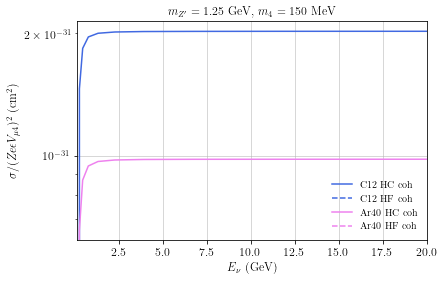

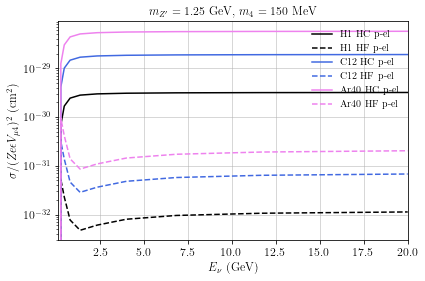

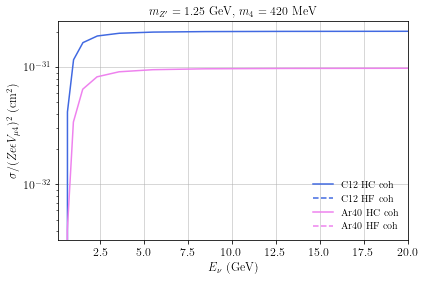

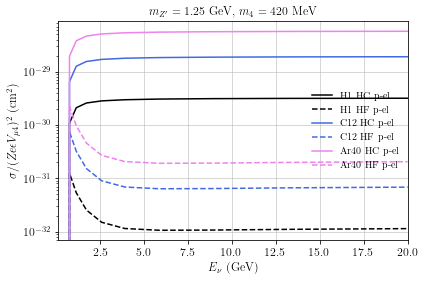

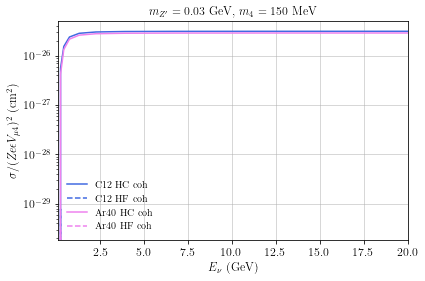

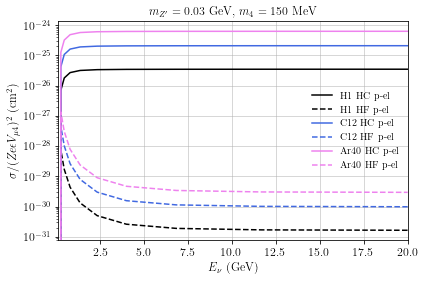

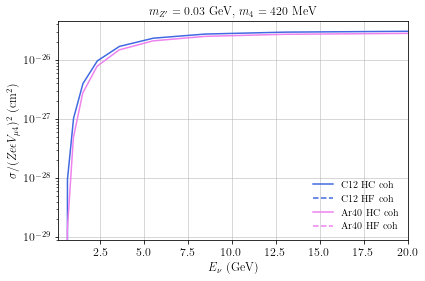

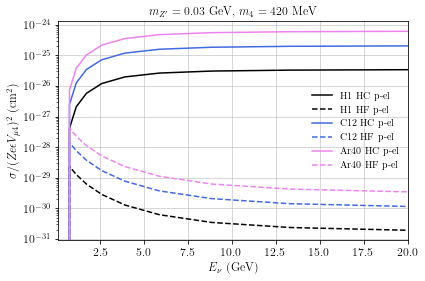

In [54]:
plot_xsecs(mcs_H_150, regime = 'coherent')
plot_xsecs(mcs_H_150, regime = 'p-el')
 
plot_xsecs(mcs_H_420, regime = 'coherent')
plot_xsecs(mcs_H_420, regime = 'p-el')
 
plot_xsecs(mcs_L_150, regime = 'coherent')
plot_xsecs(mcs_L_150, regime = 'p-el')
 
plot_xsecs(mcs_L_420, regime = 'coherent')
plot_xsecs(mcs_L_420, regime = 'p-el')

#### Differential cross section

Text(0, 0.5, '$d\\sigma/dQ^2$ (cm$^2$)')

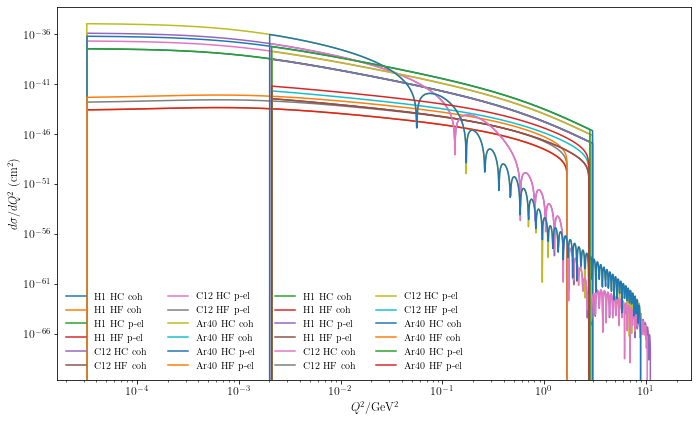

In [55]:
from DarkNews import phase_space as ps
Enu = 2
fig, ax = dn.plot_tools.std_fig(ax_form=[0.1,0.15,0.88,0.74], figsize=(10,7))
def plot_diff_xsec_Q2(MCs, Enu):
    
    for key, mc in MCs.items():
        Q2range=np.geomspace(ps.upscattering_Q2min(Enu, mc.m_ups, mc.MA),
                    ps.upscattering_Q2max(Enu, mc.m_ups, mc.MA),
                    1000)
        ax.plot(Q2range, mc.diff_xsec_Q2(Enu=Enu, Q2 = Q2range), label = f'{key}'.replace('_', ' ').replace('flipping','HF').replace('conserving','HC').replace('coherent','coh'))


plot_diff_xsec_Q2(mcs_L_150, Enu)
plot_diff_xsec_Q2(mcs_L_420, Enu)
ax.legend(loc='lower left', ncol=4, frameon=False)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$Q^2$/GeV$^2$")
ax.set_ylabel(r"$d\sigma/dQ^2$ (cm$^2$)")